## ANN
使用 TensorFlow 或 PyTorch 實作類神經網路模型預測股票價格（TensorFlow 使用 Dense layer；PyTorch 使用 Linear layer）。
說明：使用收盤價或技術指標預測，預測N日後的股價。

In [1]:
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

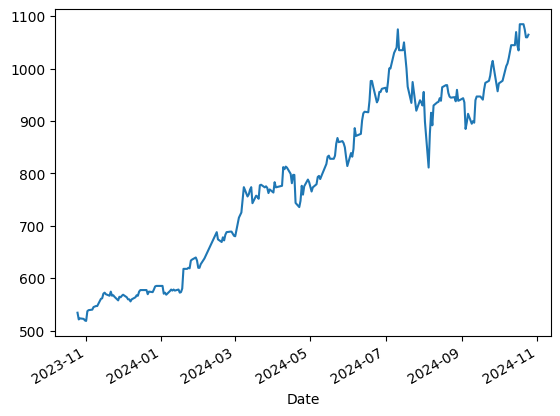

In [2]:
taiwan_2330_stock = yf.Ticker("2330.TW")      ## 我以台積電作為我的股票
data  = taiwan_2330_stock.history(period="1y")   ## 我抓取的時間是一年
data['Close'].plot() # 畫出收盤價圖片

close_prices = data['Close']  ## 選擇收盤價作為預測目標

In [3]:
close_prices_last = close_prices[ : -10]
#print(len(close_prices_last))

close_prices_next = close_prices[-10: ]

In [4]:
feature = []
label = []

for i in range( len(close_prices.values) - 29) :
    feature.append([])
    label.append([])
    feature[i].append(close_prices.values[i: i+20])
    label[i].append(close_prices.values[i+20: i+30])

In [5]:
train_size = int(len(feature) -1)
train_x, test_x =  feature[ :train_size], feature[train_size: ]
train_y, test_y   =  label[ :train_size], label[train_size: ]
train_x, test_x , train_y, test_y = torch.FloatTensor(train_x) , torch.FloatTensor(test_x), torch.FloatTensor(train_y), torch.FloatTensor(test_y)


<ipython-input-5-03f4394805a6>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  train_x, test_x , train_y, test_y = torch.FloatTensor(train_x) , torch.FloatTensor(test_x), torch.FloatTensor(train_y), torch.FloatTensor(test_y)


In [6]:
##定義ANN 類別

class SimpleANN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleANN, self).__init__()
        # 定義層
        self.fc1 = nn.Linear(input_size, hidden_size1) ## 第一隱藏層
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)  ## 第二隱藏層
        self.fc3 = nn.Linear(hidden_size2, output_size)  ## 輸出層
        self.relu = nn.ReLU() ## 激活函數

    def forward(self, x):         ## 有這一層的主要用意是什麼??   ## 向前傳波的意識??
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
# 超參數
input_size = 20 # 輸入特徵值
hidden_size1 = 64 ## 第一隱藏層的節點數
hidden_size2 = 32 ## 第二隱藏層的節點數
output_size = 10  # 輸出節點數


In [8]:
# 初始化模型 、 損失函數 和優化器
model = SimpleANN(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.MSELoss()    ## 例如使用均方誤差損失
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# 訓練過程範例
num_epochs = 20000
for epoch in range(num_epochs):
    ## 前向傳
    outputs = model(train_x)
    loss = criterion(outputs, train_y)

    ## 反向傳播和 優化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/20000], Loss: 583521.3750
Epoch [20/20000], Loss: 459919.6562
Epoch [30/20000], Loss: 294222.0625
Epoch [40/20000], Loss: 160665.0312
Epoch [50/20000], Loss: 76432.5312
Epoch [60/20000], Loss: 25283.2637
Epoch [70/20000], Loss: 6935.8740
Epoch [80/20000], Loss: 3350.2253
Epoch [90/20000], Loss: 3207.8594
Epoch [100/20000], Loss: 3025.6682
Epoch [110/20000], Loss: 2829.5049
Epoch [120/20000], Loss: 2753.3079
Epoch [130/20000], Loss: 2732.5364
Epoch [140/20000], Loss: 2724.3599
Epoch [150/20000], Loss: 2717.3149
Epoch [160/20000], Loss: 2711.1328
Epoch [170/20000], Loss: 2705.2463
Epoch [180/20000], Loss: 2699.5459
Epoch [190/20000], Loss: 2693.7720
Epoch [200/20000], Loss: 2687.8486
Epoch [210/20000], Loss: 2681.8093
Epoch [220/20000], Loss: 2675.6536
Epoch [230/20000], Loss: 2669.3743
Epoch [240/20000], Loss: 2662.9807
Epoch [250/20000], Loss: 2656.4766
Epoch [260/20000], Loss: 2649.8662
Epoch [270/20000], Loss: 2643.1489
Epoch [280/20000], Loss: 2636.3157
Epoch [290/20000], 

In [10]:
## 切換模型到評估模式
model.eval()  ## 這一步會停用 dropout  或 batch normalization(諾模型中有)

## 使用新的數據進行預測
with torch.no_grad():  ## 關閉梯度追蹤，減少記憶體使用
    predictions = model(test_x)


In [11]:
predictions = predictions.numpy()  ## 如果 x_test 是 CPU 張量


In [12]:
print(predictions)
print(test_y.numpy())
print(close_prices_next.values)


[[[1045.7664 1049.9581 1053.7542 1062.3647 1066.4412 1072.7148 1073.9745
   1077.2964 1085.1414 1088.2268]]]
[[[1045. 1070. 1045. 1035. 1085. 1085. 1075. 1060. 1060. 1065.]]]
[1045. 1070. 1045. 1035. 1085. 1085. 1075. 1060. 1060. 1065.]


In [13]:
# 加入時間索引
predictions_data = np.array(predictions).flatten()  ## 將資料展平成一維
predictions_data = pd.Series(predictions_data[0:len(close_prices_next)], index= close_prices_next.index, name='Date')


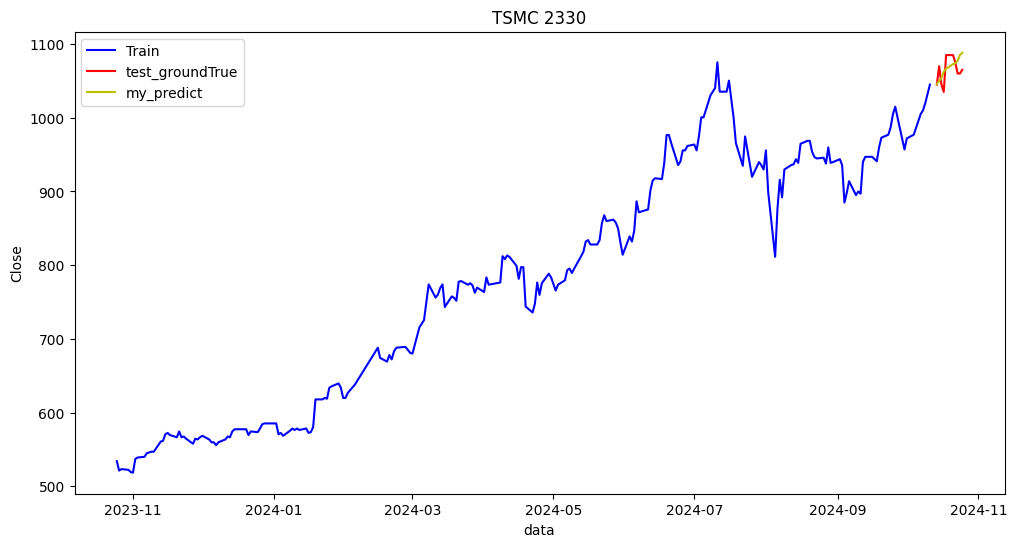

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(close_prices_last, 'b', label='Train')
plt.plot(close_prices_next, 'r', label='test_groundTrue')
plt.plot(predictions_data, 'y', label='my_predict')
plt.title('TSMC 2330')
plt.xlabel('data')
plt.ylabel('Close')
plt.legend()
plt.show()